In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import sys

sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata

seed = 256
torch.manual_seed(seed)
np.random.seed(seed)

## Plotting Utilities

In [3]:
from matplotlib.patches import Rectangle

def plot_hypercubes(ax, hypercubes: torch.Tensor, color="C0", alpha=0.4):
    for h in hypercubes:
        low, high = h[:, 0], h[:, 1]
        side_lengths = high - low

        patch = Rectangle(low, side_lengths[0], side_lengths[1], facecolor=color, alpha=alpha)
        ax.add_patch(patch)

def plot_as_heatmap(ax, x, y, z, n_points=1000, cmap="viridis", norm=None, interpolation="linear"):
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    X, Y = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
    Z = griddata((x, y), z, (X, Y), method=interpolation)
    pcm = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap=cmap, norm=norm)
    return pcm

## Data Generation

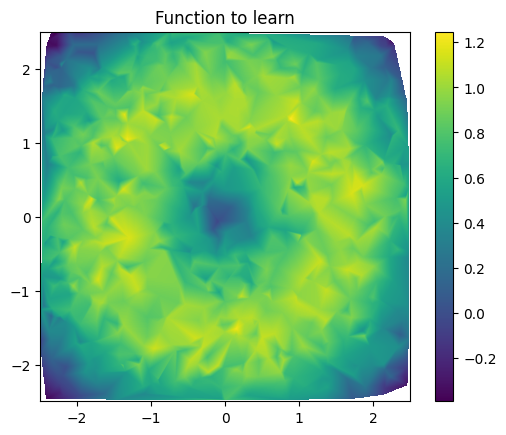

In [4]:
from torch_mas.data import DataBuffer

device = "cpu"

num_samples = 1000
test_size = 1000
num_features = 2
noise_level = 0.1
X = (torch.rand(num_samples, num_features)-0.5)*5
y = (torch.sin(torch.sqrt(X[:, 0]**2 + X[:, 1]**2)) + torch.randn(X.size(0))*noise_level).unsqueeze(-1)
X_test = (torch.rand(num_samples, num_features)-0.5)*5
y_test = (torch.sin(torch.sqrt(X_test[:, 0]**2 + X_test[:, 1]**2))).unsqueeze(-1)
dataset = DataBuffer(X, y, device=device)

X.shape, y.shape

fig = plt.gcf()
ax = plt.gca()
# pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], y_test)
pcm = plot_as_heatmap(ax, X[:, 0], X[:, 1], y)
ax.set_title("Function to learn")
fig.colorbar(pcm)

## Model Training

In [77]:
import time
from torch_mas.batch.trainer import ConsensusTrainer as Trainer
from torch_mas.batch.internal_model import LinearWithMemory, LinearSGD
from torch_mas.batch.activation_function import BaseActivation, AVRTActivation


# activation = BaseActivation(
#     dataset.input_dim, 
#     dataset.output_dim, 
#     alpha=0.1, 
#     device=device
# )
activation = AVRTActivation(
    dataset.input_dim, 
    dataset.output_dim, 
    device=device
)

# internal_model = LinearWithMemory(
#     dataset.input_dim, 
#     dataset.output_dim, 
#     l1=0.1, 
#     memory_length=10,
#     device=device
# )
internal_model = LinearSGD(
    dataset.input_dim,
    dataset.output_dim,
    lr=1e-2,
    device=device
)

model = Trainer(
    activation,
    internal_model,
    R=[0.5, 0.4],
    # imprecise_th=0.01,
    # bad_th=0.1,
    outlier_factor=3.0,
    n_epochs=20,
    batch_size=64,
    device=device
)

t = time.time()
model.fit(dataset)
tt = time.time() - t
print(f"Total training time: {tt}s")

print("Number of agents created:", model.n_agents)

Total training time: 4.604595184326172s
Number of agents created: 209


In [78]:
# %lprun -f model.agents.update_model model.fit(dataset)

### Agents Visualization

Text(0, 0.5, 'Y')

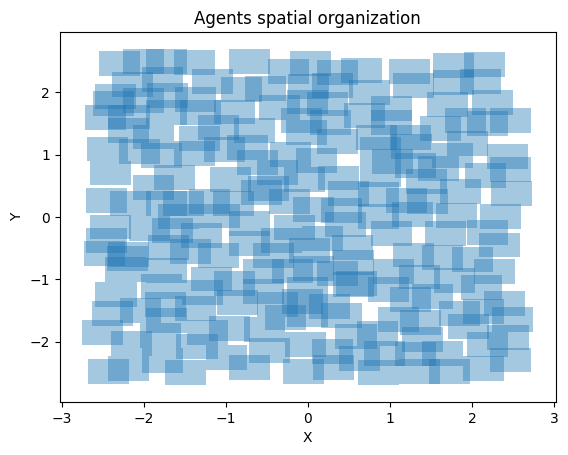

In [79]:
ax = plt.gca()
ax.scatter(dataset.X.cpu()[:, 0], dataset.X.cpu()[:, 1], marker="o", c="r", alpha=0)
plot_hypercubes(ax, model.activation.orthotopes.detach().cpu().numpy())
ax.set_title("Agents spatial organization")
ax.set_xlabel("X")
ax.set_ylabel("Y")

### Predictions Visualization

Total Prediction time: 0.024015188217163086s for 1000 samples
Prediction time per sample: 2.4015188217163087e-05s
Mean Squared Error: 0.010716695


Text(0.5, 1.0, 'Predictions on test')

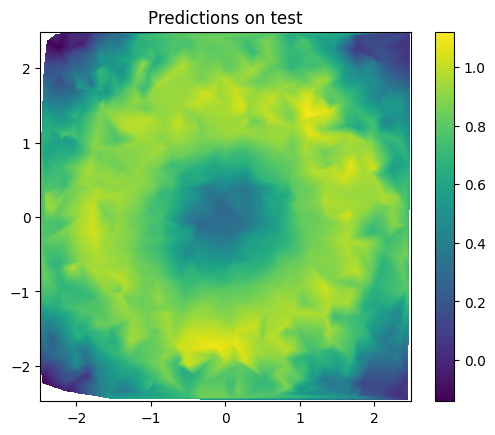

In [80]:
import time

t = time.time()
y_pred = model.predict(X_test)
tt = time.time() - t
tps = tt / X_test.size(0)
print(f"Total Prediction time: {tt}s for {X_test.size(0)} samples")
print(f"Prediction time per sample: {tps}s")

mse = ((y_pred - y_test) ** 2).mean()
print("Mean Squared Error:", mse.detach().numpy())

fig = plt.gcf()
ax = plt.gca()
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], y_pred.detach().squeeze(), interpolation="linear", n_points=1000)
fig.colorbar(pcm)
ax.set_title("Predictions on test")

In [81]:
m = model.internal_model.clone()

In [82]:
m.models.device, model.internal_model.models.device

(device(type='cpu'), device(type='cpu'))